In [33]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
#%matplotlib inline

import string
import os
import glob
import tensorflow as tf
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

In [34]:
token_path = "/content/drive/MyDrive/dataset_captioning/Flickr8K_Text/Flickr8k.token.txt"
train_images_path = '/content/drive/MyDrive/dataset_captioning/Flickr8K_Text/Flickr_8k.trainImages.txt'
val_images_path = '/content/drive/MyDrive/dataset_captioning/Flickr8K_Text/Flickr_8k.devImages.txt'
test_images_path = '/content/drive/MyDrive/dataset_captioning/Flickr8K_Text/Flickr_8k.testImages.txt'
images_path = '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/'
test_path ='/content/drive/MyDrive/dataset_captioning/test_image/'
glove_path = '/content/drive/MyDrive/Colab Notebooks/embedding/'

In [35]:
doc = open(token_path,'r').read()

# Split captions per image
table = str.maketrans('', '', string.punctuation) #translate table

descriptions = dict()
for line in doc.split('\n'):
        tokens = line.split()
        if len(line) > 2:
            image_id = tokens[0].split('.')[0]  # get image name

            image_desc = ' '.join(tokens[1:])           # combine caption from array to string
            image_desc = image_desc.lower()             # lowercase
            image_desc = image_desc.translate(table)    # remove punctuations

            if image_id not in descriptions:
                descriptions[image_id] = list()
            descriptions[image_id].append(image_desc)

In [36]:
# Create train and test set

img = glob.glob(images_path + '*.jpg')  # read images name in folder
train_images = set(open(train_images_path, 'r').read().strip().split('\n')) # read train txt file
train_img = []
for i in img:
    if i[len(images_path):] in train_images:
        # append images path into train_img if it's in train txt file
        train_img.append(i)

print(train_img)

val_images = set(open(val_images_path, 'r').read().strip().split('\n'))
val_img = []
for i in img:
    if i[len(images_path):] in val_images:
        # append images path into train_img if it's in train txt file
        val_img.append(i)

print(val_img)

imgs = glob.glob(test_path + '*.jpg')
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for j in imgs:
    if j[len(test_path):] in test_images:
        test_img.append(j)

print(test_img)

['/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/793.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/782.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/769.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/13.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/8.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/801.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/716.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/771.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/643.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/5.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/796.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/3.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/764.jpg', '/content/drive/MyDrive/dataset_captioning/Flicker8k_Dataset/827.jpg', '/content/dr

In [37]:
# Create training captions

# Read train txt file then append image filename to 'train'
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
        identifier = line.split('.')[0]
        dataset.append(identifier)

train = set(dataset)

# Create another dict of description for training files only
train_descriptions = dict()
for image_id, image_desc_arr in descriptions.items():
    if image_id in train:
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        desc = ['startseq ' + image_desc + ' endseq' for image_desc in image_desc_arr]
        train_descriptions[image_id] = desc


In [38]:
# Validation captions

# Read train txt file then append image filename to 'train'
doc = open(val_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
        identifier = line.split('.')[0]
        dataset.append(identifier)

val = set(dataset)

# Create another dict of description for training files only
val_descriptions = dict()
for image_id, image_desc_arr in descriptions.items():
    if image_id in val:
        if image_id not in val_descriptions:
            val_descriptions[image_id] = list()
        desc = ['startseq ' + image_desc + ' endseq' for image_desc in image_desc_arr]
        val_descriptions[image_id] = desc


---

In [39]:
# Create vocabulary set

vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 397


In [40]:
word_count_threshold = 1
word_counts = {}
nsents = 0
for key, val in train_descriptions.items():
    for sent in val:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 379


In [41]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1
print('Vocab Size', vocab_size)

all_desc = list()
for key in train_descriptions.keys():
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

embedding_dim = 100

Vocab Size 380
Description Length: 22


In [42]:
embeddings_index = {}
f = open(os.path.join(glove_path, 'geo_glove.txt'), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [43]:
model = tf.keras.applications.xception.Xception()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_4[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

-----

In [44]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image)
    fea_vec = model.predict(image)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    #print(fea_vec.shape)
    return fea_vec

In [45]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images_path):]] = encode(img)

train_features = encoding_train

1/1 [==============================] - 0s 37ms/step


In [46]:
encoding_val = {}
for img in val_img:
    encoding_val[img[len(images_path):]] = encode(img)

val_features = encoding_val

1/1 [==============================] - 0s 20ms/step


In [47]:
encoding_test = {}
for img in test_img:
    encoding_test[img[len(test_path):]] = encode(img)

test_features = encoding_test
#print(test_features)

1/1 [==============================] - 0s 24ms/step


X Shape (1, 299, 299, 3)
1/1 [==============================] - 0s 33ms/step
Fea Vec Shape (1, 2048)
Fea Vec Shape (2048,)


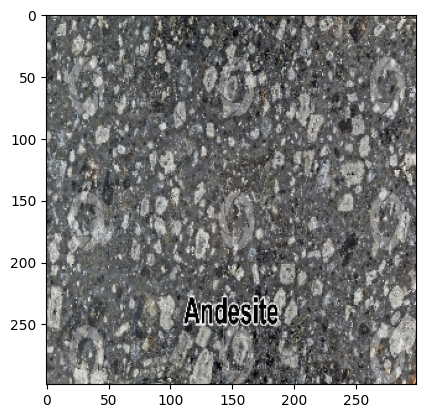

In [48]:
# Print image preprocess result
for img_path in test_img:
    img = image.load_img(img_path, target_size=(299, 299))
    #preprocess
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    plt.imshow(img)
    print("X Shape", x.shape)

    #predict
    fea_vec = model.predict(x)
    print("Fea Vec Shape", fea_vec.shape)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    print("Fea Vec Shape", fea_vec.shape)
    break

-----

In [49]:
maxlen = max_length #22
vocab_size = 400 #400

#feature map inputs
inputs1 = Input(shape=(2048,))
print('input s1 ',inputs1.shape)
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(vocab_size, activation='relu')(fe1)
print('fe2 = ', fe2.shape)

#transformers block

inputs2 = layers.Input(shape=(maxlen,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(400)(se2)

#se3 = layers.Dense(vocab_size, activation="softmax")(x)

decoder1 = add([fe2, se3])
print('decoder1 = ', decoder1.shape)
decoder2 = Dense(vocab_size, activation='relu')(decoder1)
print('decoder2 = ', decoder2.shape)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
print('output merger ',outputs.shape)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()


#model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


input s1  (None, 2048)
fe2 =  (None, 400)
decoder1 =  (None, 400)
decoder2 =  (None, 400)
output merger  (None, 400)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 22)]                 0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 22, 100)              40000     ['input_6[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['inpu

In [50]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0

Epoch 1/500
232/232 [==============================] - 27s 94ms/step - loss: 4.0763 - accuracy: 0.2352 - val_loss: 6.9592 - val_accuracy: 0.1685
Epoch 2/500
232/232 [==============================] - 19s 80ms/step - loss: 3.5343 - accuracy: 0.2990 - val_loss: 6.4780 - val_accuracy: 0.2625
Epoch 3/500
232/232 [==============================] - 18s 76ms/step - loss: 3.1669 - accuracy: 0.3228 - val_loss: 6.3003 - val_accuracy: 0.2580
Epoch 4/500
232/232 [==============================] - 19s 82ms/step - loss: 2.8983 - accuracy: 0.3364 - val_loss: 5.5916 - val_accuracy: 0.2798
Epoch 5/500
232/232 [==============================] - 18s 77ms/step - loss: 2.6836 - accuracy: 0.3578 - val_loss: 4.9379 - val_accuracy: 0.2822
Epoch 6/500
232/232 [==============================] - 17s 73ms/step - loss: 2.4707 - accuracy: 0.4066 - val_loss: 5.5530 - val_accuracy: 0.2706
Epoch 7/500
232/232 [==============================] - 19s 82ms/step - loss: 2.4254 - accuracy: 0.4029 - val_loss: 5.4106 - val_ac

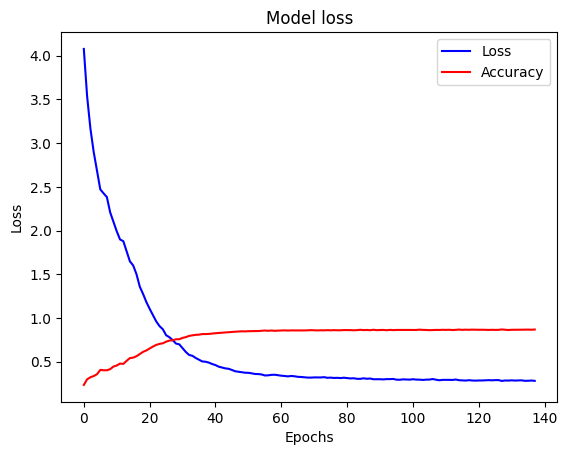

In [51]:
epochs = 1
batch_size = 3
steps = len(train_descriptions)//batch_size
val_steps = len(val_descriptions)//batch_size

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=0)

#generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
    valid_generator = data_generator(val_descriptions, val_features, wordtoix, max_length, batch_size)
    history = model.fit(generator, validation_data=valid_generator, epochs=500, steps_per_epoch=steps, validation_steps=val_steps, callbacks=callback, verbose=1)


    #model.save('../vgg16/modelE40_' + str(i) + '.h5')

    print(history.history['loss'])
    print(history.history['accuracy'])

    # Plot training & validation loss values
    plt.plot(history.history['loss'], 'b')
    plt.plot(history.history['accuracy'], 'r')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Loss','Accuracy'], loc='upper right')
    plt.show()

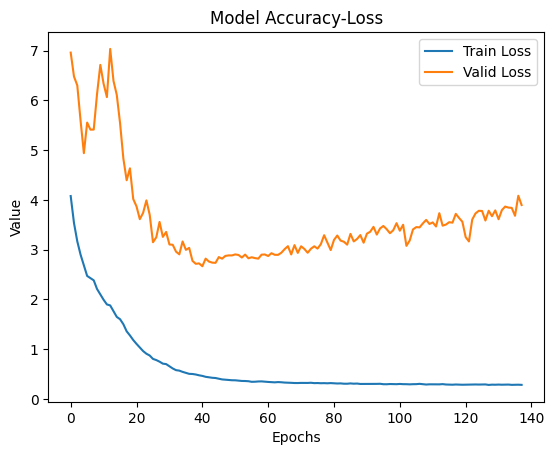

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy-Loss')
plt.ylabel('Value')
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Valid Loss'], loc='upper right')
plt.show()

In [53]:
# Save the weights
model.save('/content/drive/MyDrive/Colab Notebooks/model/xception_lstm.keras')

---

In [54]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/model/xception_lstm.keras')
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, 3)
for i in generator:
    loss, acc = model.evaluate(i[0], i[1], verbose=2)
    break

4/4 - 2s - loss: 0.1636 - accuracy: 0.9196 - 2s/epoch - 517ms/step


In [55]:
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model

#model = load_model('../vgg16/ctrans33_500.h5')

def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)


    return final

In [56]:
import pandas as pd

def beam_search_predictions(image, beam_index = 3):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    i = 0
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            #print(par_caps)
            #print('\n')

            preds = model.predict([image,par_caps], verbose=0)
            #print(preds)
            #print('\n')

            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:

                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                df = pd.DataFrame(temp, columns = ['Sequence Word','Probabilty'])
                #print(df.head(10))
                #print('\n')


        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
        df_word = pd.DataFrame(start_word)
        #print('\n')


    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []

    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    #print(final_caption)

    return final_caption

In [57]:
import tensorflow as tf
import nltk
nltk.download('punkt')

from nltk import word_tokenize

def tokeniser(text_generation):
    token = []
    #i = 0
    for in_txt in text_generation:
        refer = word_tokenize(in_txt)
        token.append(refer)
        #print(token[i])
        #i =+ 1


    list_token = token
    return list_token

#print(tokeniser(descriptions['1']))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [58]:
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns


average1 = 0
average2 = 0
average3 = 0
average4 = 0
i  = 0
b1 = 0
b2 = 0
b3 = 0
b4 = 0

captions = []
for img in list(encoding_test.keys()):
    print(img)
    picture = plt.imread(test_path + img)
    print('nama file = ' + img)
    image = encoding_test[img].reshape(1,2048)
    plt.imshow(picture)
    plt.show()

    text = img.split('.')[0]
    print(descriptions[text])
    #print('\n')

    print("Greedy Search:", greedySearch(image))

    #print("Beam Search K = 3:", beam_search_predictions(image, beam_index = 3))

    references = tokeniser(descriptions[text])

    candidates = word_tokenize(greedySearch(image))

    b1 = sentence_bleu(references, candidates, weights=(1, 0, 0, 0))
    b2 = sentence_bleu(references, candidates, weights=(0, 0.5, 0, 0))
    b3 = sentence_bleu(references, candidates, weights=(0, 0.3, 0.3, 0))
    b4 = sentence_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))

    print('BLEU-1: %f' % b1 )
    print('BLEU-2: %f' % b2 )
    print('BLEU-3: %f' % b3 )
    print('BLEU-4: %f' % b4 )

    average1 = average1 + b1
    average2 = average2 + b2
    average3 = average3 + b3
    average4 = average4 + b4

    print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    print('\n')

    captions.append([candidates, references,'B@1 %f' %b1,'B@2 %f' %b2,'B@3 %f' %b3,'B@4 %f' %b4])

    i = i + 1



Blue_1 = average1 / i
Blue_2 = average2 / i
Blue_3 = average3 / i
Blue_4 = average4 / i


print('Rata BLEU-1: %f' % Blue_1 )
print('Rata BLEU-2: %f' % Blue_2 )
print('Rata BLEU-3: %f' % Blue_3 )
print('Rata BLEU-4: %f' % Blue_4 )

captions.append(['B@1 %f' % Blue_1,'B@2 %f' % Blue_2,'B@3 %f' % Blue_3,'B@4 %f' % Blue_4])

Output hidden; open in https://colab.research.google.com to view.

In [59]:
del encoding_train['210.jpg']
del encoding_train['279.jpg']

In [60]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
average1 = 0
average2 = 0
average3 = 0
average4 = 0
i  = 0

captions = []
for img in list(encoding_train.keys()):
    picture = plt.imread(images_path + img)
    image = encoding_train[img].reshape(1,2048)

    text = img.split('.')[0]

    references = tokeniser(descriptions[text])

    candidates = word_tokenize(greedySearch(image))

    b1 = sentence_bleu(references, candidates, weights=(1, 0, 0, 0))
    b2 = sentence_bleu(references, candidates, weights=(0, 0.5, 0, 0))
    b3 = sentence_bleu(references, candidates, weights=(0, 0.3, 0.3, 0))
    b4 = sentence_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))

    average1 = average1 + b1
    average2 = average2 + b2
    average3 = average3 + b3
    average4 = average4 + b4

    captions.append([candidates, references,'B@1 %f' %b1,'B@2 %f' %b2,'B@3 %f' %b3,'B@4 %f' %b4])

    i = i + 1
    if i == 700 : break



Blue_1 = average1 / i
Blue_2 = average2 / i
Blue_3 = average3 / i
Blue_4 = average4 / i


print('Rata BLEU-1: %f' % Blue_1 )
print('Rata BLEU-2: %f' % Blue_2 )
print('Rata BLEU-3: %f' % Blue_3 )
print('Rata BLEU-4: %f' % Blue_4 )

captions.append(['B@1 %f' % Blue_1,'B@2 %f' % Blue_2,'B@3 %f' % Blue_3,'B@4 %f' % Blue_4])

Rata BLEU-1: 0.990610
Rata BLEU-2: 0.959046
Rata BLEU-3: 0.817602
Rata BLEU-4: 0.666829


In [61]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
average1 = 0
average2 = 0
average3 = 0
average4 = 0
i  = 0

captions = []
for img in list(encoding_val.keys()):
    picture = plt.imread(images_path + img)
    image = encoding_val[img].reshape(1,2048)

    text = img.split('.')[0]

    references = tokeniser(descriptions[text])

    candidates = word_tokenize(greedySearch(image))

    b1 = sentence_bleu(references, candidates, weights=(1, 0, 0, 0))
    b2 = sentence_bleu(references, candidates, weights=(0, 0.5, 0, 0))
    b3 = sentence_bleu(references, candidates, weights=(0, 0.3, 0.3, 0))
    b4 = sentence_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25))

    average1 = average1 + b1
    average2 = average2 + b2
    average3 = average3 + b3
    average4 = average4 + b4

    captions.append([candidates, references,'B@1 %f' %b1,'B@2 %f' %b2,'B@3 %f' %b3,'B@4 %f' %b4])

    i = i + 1
    if i == 700 : break



Blue_1 = average1 / i
Blue_2 = average2 / i
Blue_3 = average3 / i
Blue_4 = average4 / i


print('Rata BLEU-1: %f' % Blue_1 )
print('Rata BLEU-2: %f' % Blue_2 )
print('Rata BLEU-3: %f' % Blue_3 )
print('Rata BLEU-4: %f' % Blue_4 )

captions.append(['B@1 %f' % Blue_1,'B@2 %f' % Blue_2,'B@3 %f' % Blue_3,'B@4 %f' % Blue_4])

Rata BLEU-1: 0.408135
Rata BLEU-2: 0.214926
Rata BLEU-3: 0.131435
Rata BLEU-4: 0.099749
